In [2]:
import pandas as pd
from statsmodels.tsa.ar_model import AR
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt 

# Data Wrangling
## 1. Data exploration

In [3]:
data = pd.read_csv("118B.csv")
data

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


In [4]:
#take a look at the missing values in our dataset
data.isna().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

As 70% of data miss HDI value, we will discard this feature for now, and save for future analysis
At the same time, "Generation" is an alternative representation of "Age", thus we discard this column

In [5]:
data = data.drop(["HDI for year","generation"],axis = 1)

## 2. Add Latitude and Longitude features to each country in the data set
dataset used: https://www.kaggle.com/eidanch/counties-geographic-coordinates#__sid=js0

In [6]:
geo = pd.read_csv("countries.csv")

In [7]:
geo

,country,latitude,longitude,name
0,AD,42.546245,1.601554,Andorra
1,AE,23.424076,53.847818,United Arab Emirates
2,AF,33.939110,67.709953,Afghanistan
3,AG,17.060816,-61.796428,Antigua and Barbuda
4,AI,18.220554,-63.068615,Anguilla
5,AL,41.153332,20.168331,Albania
6,AM,40.069099,45.038189,Armenia
7,AN,12.226079,-69.060087,Netherlands Antilles
8,AO,-11.202692,17.873887,Angola
9,AQ,-75.250973,-0.071389,Antarctica


In [8]:
geoOut = pd.DataFrame(columns = ["longitude","latitude"],index=  data.index)
#print the countries which names don't match in the file
for i in data["country"].unique():
    if i not in list(geo["name"]):
        print(i)
    #add longitude and latitude feature to all countries in order
    else:
        currIdx = data[data["country"]==i].index
        currGeo = geo[geo["name"]==i]
        currLat = float(currGeo["latitude"])
        currLong = float(currGeo["longitude"])
        
        geoOut.loc[currIdx,"longitude"] = currLong
        geoOut.loc[currIdx,"latitude"] = currLat

Cabo Verde
Republic of Korea
Russian Federation
Saint Vincent and Grenadines


In [9]:
# Manually add in the country with different naming conventions.
# Cabo Verde
currIdx = data[data["country"]== "Cabo Verde"].index
currLat = 15.07
currLong = -23.36

geoOut.loc[currIdx,"longitude"] = currLong
geoOut.loc[currIdx,"latitude"] = currLat

In [10]:
# South Korea
currIdx = data[data["country"]== "Republic of Korea"].index
currGeo = geo[geo["name"]=="South Korea"]
currLat = float(currGeo["latitude"])
currLong = float(currGeo["longitude"])

geoOut.loc[currIdx,"longitude"] = currLong
geoOut.loc[currIdx,"latitude"] = currLat

In [11]:
# Russia
currIdx = data[data["country"]== "Russian Federation"].index
currGeo = geo[geo["name"]=="Russia"]
currLat = float(currGeo["latitude"])
currLong = float(currGeo["longitude"])

geoOut.loc[currIdx,"longitude"] = currLong
geoOut.loc[currIdx,"latitude"] = currLat

In [12]:
# Russia
currIdx = data[data["country"]== "Saint Vincent and Grenadines"].index
currGeo = geo[geo["name"]=="Saint Vincent and the Grenadines"]
currLat = float(currGeo["latitude"])
currLong = float(currGeo["longitude"])

geoOut.loc[currIdx,"longitude"] = currLong
geoOut.loc[currIdx,"latitude"] = currLat

In [13]:
# check if successfully converted all countries
sum(geoOut["longitude"].isna())

0

In [14]:
geoOut

,longitude,latitude
0,20.1683,41.1533
1,20.1683,41.1533
2,20.1683,41.1533
3,20.1683,41.1533
4,20.1683,41.1533
5,20.1683,41.1533
6,20.1683,41.1533
7,20.1683,41.1533
8,20.1683,41.1533
9,20.1683,41.1533


## 3. Encoding (Transfer categorical data to numerical data)
- We want to transfer country, year, sex, age to numerical data
- We want to encode country by longitutde and latitude
- Use LabelEncoder for year and age
- Use one hot encoding for sex

In [15]:
encodeIn = data[["year","age"]]
encodeOut = encodeIn.copy()

In [16]:
#Use LabelEncoder for year and age
from sklearn import preprocessing 
ord_enc = preprocessing.LabelEncoder()
classes = []

for feature in encodeOut.columns:
    encodeOut[feature] = ord_enc.fit_transform(encodeIn[feature])
    classes .append(list(ord_enc.classes_))

In [17]:
encodeOut

,year,age
0,2,0
1,2,2
2,2,0
3,2,5
4,2,1
5,2,5
6,2,2
7,2,1
8,2,4
9,2,3


In [18]:
#one-hot encoding sex column
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
oneHotOut = pd.DataFrame(enc.fit_transform(data[["sex"]]).toarray(),columns = list(enc.categories_[0]))

In [19]:
oneHotOut

,female,male
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0
5,1.0,0.0
6,1.0,0.0
7,1.0,0.0
8,0.0,1.0
9,1.0,0.0


In [20]:
#concatinate columns together
processed = pd.concat([geoOut,encodeOut,oneHotOut,data[["suicides_no","population","suicides/100k pop"," gdp_for_year ($) ","gdp_per_capita ($)"]]],axis = 1)
processed = processed.rename(columns={" gdp_for_year ($) ": "gdp", "gdp_per_capita ($)": "gdp/p"})
processed["gdp"] = processed["gdp"].apply(lambda x : x.replace(",",""))
processed = processed.astype({'gdp':'int64'})

In [21]:
processed.columns

Index(['longitude', 'latitude', 'year', 'age', 'female', 'male', 'suicides_no',
       'population', 'suicides/100k pop', 'gdp', 'gdp/p'],
      dtype='object')

In [22]:
processed

,longitude,latitude,year,age,female,male,suicides_no,population,suicides/100k pop,gdp,gdp/p
0,20.1683,41.1533,2,0,0.0,1.0,21,312900,6.71,2156624900,796
1,20.1683,41.1533,2,2,0.0,1.0,16,308000,5.19,2156624900,796
2,20.1683,41.1533,2,0,1.0,0.0,14,289700,4.83,2156624900,796
3,20.1683,41.1533,2,5,0.0,1.0,1,21800,4.59,2156624900,796
4,20.1683,41.1533,2,1,0.0,1.0,9,274300,3.28,2156624900,796
5,20.1683,41.1533,2,5,1.0,0.0,1,35600,2.81,2156624900,796
6,20.1683,41.1533,2,2,1.0,0.0,6,278800,2.15,2156624900,796
7,20.1683,41.1533,2,1,1.0,0.0,4,257200,1.56,2156624900,796
8,20.1683,41.1533,2,4,0.0,1.0,1,137500,0.73,2156624900,796
9,20.1683,41.1533,2,3,1.0,0.0,0,311000,0.00,2156624900,796


## 4. Data Normalization

In [23]:
#check data features
processed.describe()

,year,age,female,male,suicides_no,population,suicides/100k pop,gdp,gdp/p
count,27820.000000,27820.000000,27820.000000,27820.000000,27820.000000,2.782000e+04,27820.000000,2.782000e+04,27820.000000
mean,16.258375,2.499425,0.500000,0.500000,242.574407,1.844794e+06,12.816097,4.455810e+11,16866.464414
std,8.469055,1.708754,0.500009,0.500009,902.047917,3.911779e+06,18.961511,1.453610e+12,18887.576472
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.780000e+02,0.000000,4.691962e+07,251.000000
25%,10.000000,1.000000,0.000000,0.000000,3.000000,9.749850e+04,0.920000,8.985353e+09,3447.000000
50%,17.000000,2.000000,0.500000,0.500000,25.000000,4.301500e+05,5.990000,4.811469e+10,9372.000000
75%,23.000000,4.000000,1.000000,1.000000,131.000000,1.486143e+06,16.620000,2.602024e+11,24874.000000
max,31.000000,5.000000,1.000000,1.000000,22338.000000,4.380521e+07,224.970000,1.812071e+13,126352.000000


In [24]:
# Normalization on data ()
# We perform Z normalization on some of our data
processedN = processed.copy()
processedN[["suicides_no","population","gdp","gdp/p"]] = processedN[["suicides_no","population","gdp","gdp/p"]].apply(stats.zscore)
                                                                     

In [25]:
processedN

,longitude,latitude,year,age,female,male,suicides_no,population,suicides/100k pop,gdp,gdp/p
0,20.1683,41.1533,2,0,0.0,1.0,-0.245639,-0.391617,6.71,-0.305056,-0.850864
1,20.1683,41.1533,2,2,0.0,1.0,-0.251182,-0.392870,5.19,-0.305056,-0.850864
2,20.1683,41.1533,2,0,1.0,0.0,-0.253400,-0.397548,4.83,-0.305056,-0.850864
3,20.1683,41.1533,2,5,0.0,1.0,-0.267811,-0.466035,4.59,-0.305056,-0.850864
4,20.1683,41.1533,2,1,0.0,1.0,-0.258943,-0.401485,3.28,-0.305056,-0.850864
5,20.1683,41.1533,2,5,1.0,0.0,-0.267811,-0.462507,2.81,-0.305056,-0.850864
6,20.1683,41.1533,2,2,1.0,0.0,-0.262268,-0.400335,2.15,-0.305056,-0.850864
7,20.1683,41.1533,2,1,1.0,0.0,-0.264486,-0.405857,1.56,-0.305056,-0.850864
8,20.1683,41.1533,2,4,0.0,1.0,-0.267811,-0.436457,0.73,-0.305056,-0.850864
9,20.1683,41.1533,2,3,1.0,0.0,-0.268920,-0.392103,0.00,-0.305056,-0.850864


In [26]:
processedN.describe()

,year,age,female,male,suicides_no,population,suicides/100k pop,gdp,gdp/p
count,27820.000000,27820.000000,27820.000000,27820.000000,2.782000e+04,27820.000000,27820.000000,2.782000e+04,2.782000e+04
mean,16.258375,2.499425,0.500000,0.500000,8.173029e-18,0.000000,12.816097,1.634606e-17,-1.082926e-16
std,8.469055,1.708754,0.500009,0.500009,1.000018e+00,1.000018,18.961511,1.000018e+00,1.000018e+00
min,0.000000,0.000000,0.000000,0.000000,-2.689200e-01,-0.471537,0.000000,-3.065073e-01,-8.797192e-01
25%,10.000000,1.000000,0.000000,0.000000,-2.655942e-01,-0.446683,0.920000,-3.003581e-01,-7.105044e-01
50%,17.000000,2.000000,0.500000,0.500000,-2.412048e-01,-0.361643,5.990000,-2.734388e-01,-3.968005e-01
75%,23.000000,4.000000,1.000000,1.000000,-1.236923e-01,-0.091686,16.620000,-1.275321e-01,4.239654e-01
max,31.000000,5.000000,1.000000,1.000000,2.449518e+01,10.726876,224.970000,1.215969e+01,5.796800e+00


# Exploratory Data Analysis

In [27]:
female = processedN[processedN['female']==1]
femaleavr = female.groupby("year",as_index=False)["suicides/100k pop"].mean()

In [28]:
male = processedN[processedN['male']==1]
maleavr = male.groupby("year",as_index=False)["suicides/100k pop"].mean()

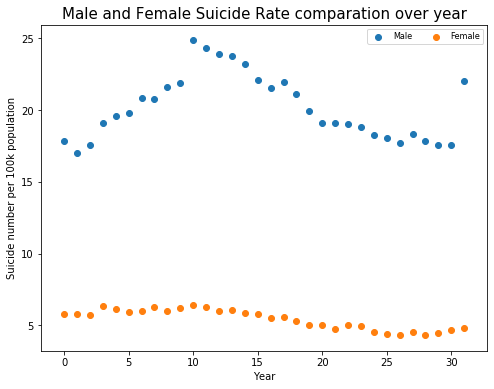

In [29]:
#Plotting the results
fig, ax = plt.subplots(figsize=(8,6))
m = plt.scatter(maleavr["year"], maleavr["suicides/100k pop"])
f = plt.scatter(femaleavr["year"], femaleavr["suicides/100k pop"])
#sns.scatterplot(lr_y_pred, x, ax=ax, color=sns.husl_palette(10)[0])
#sns.lineplot([0, 175], [0, 175], color=sns.husl_palette(10)[5], ax=ax)
plt.xlabel('Year')
plt.ylabel('Suicide number per 100k population')
plt.title('Male and Female Suicide Rate comparation over year', size=15)
plt.legend((m, f),
           ('Male', 'Female'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
plt.show()

In [30]:
gen1 = processedN[processedN['age']==0]
gen1 = gen1.groupby("year",as_index=False)["suicides/100k pop"].mean()

gen2 = processedN[processedN['age']==1]
gen2 = gen2.groupby("year",as_index=False)["suicides/100k pop"].mean()
gen3 = processedN[processedN['age']==2]
gen3 = gen3.groupby("year",as_index=False)["suicides/100k pop"].mean()
gen4 = processedN[processedN['age']==3]
gen4 = gen4.groupby("year",as_index=False)["suicides/100k pop"].mean()
gen5 = processedN[processedN['age']==4]
gen5 = gen5.groupby("year",as_index=False)["suicides/100k pop"].mean()
gen6 = processedN[processedN['age']==5]
gen6 = gen6.groupby("year",as_index=False)["suicides/100k pop"].mean()

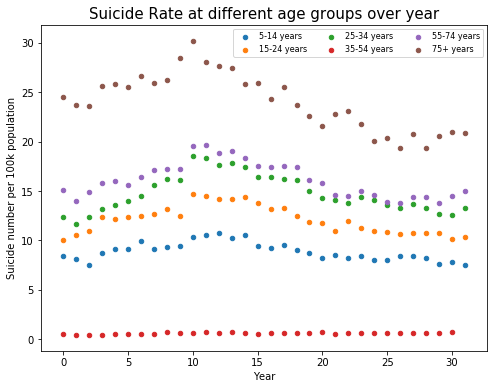

In [31]:
#Plotting the results
fig, ax = plt.subplots(figsize=(8,6))
a = plt.scatter(gen1["year"], gen1["suicides/100k pop"], s=20)
b = plt.scatter(gen2["year"], gen2["suicides/100k pop"], s=20)
c = plt.scatter(gen3["year"], gen3["suicides/100k pop"], s=20)
d = plt.scatter(gen4["year"], gen4["suicides/100k pop"], s=20)
e = plt.scatter(gen5["year"], gen5["suicides/100k pop"], s=20)
f = plt.scatter(gen6["year"], gen6["suicides/100k pop"], s=20)
plt.legend((a, b, c, d, e, f),
           ('5-14 years', '15-24 years', '25-34 years', '35-54 years', '55-74 years','75+ years'),
           scatterpoints=1,
           loc='upper right',
           ncol=3,
           fontsize=8)
plt.xlabel('Year')
plt.ylabel('Suicide number per 100k population')
plt.title('Suicide Rate at different age groups over year', size=15)
plt.show()

# Modelling and Prediction

In [32]:
# Import packages for splitting hte dataset
from sklearn.model_selection import train_test_split

In [33]:
# Selecting the dependent and independent features & set trainning data
x = processedN[['longitude', 'latitude', 'year', 'age', 'female', 'male','population','gdp', 'gdp/p']]
y = processedN['suicides/100k pop']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2)


# drop age column for validation
x_drop_age = processedN[['longitude', 'latitude', 'year', 'female', 'male','population','gdp', 'gdp/p']]
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(x_drop_age, y, test_size=.2)


# drop gdp column for validation
x_drop_gdp = processedN[['longitude', 'latitude', 'year', 'female', 'male','population','age', 'gdp/p']]
X_train_gdp, X_test_gdp, y_train_gdp, y_test_gdp = train_test_split(x_drop_gdp, y, test_size=.2)


In [34]:
# Dataframe for feature Importance
featureImportance = pd.DataFrame(index= x.columns)

## 1. Linear Regression

In [35]:
#Importing the Linear Regression algorithm 
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
lr_y_pred = lr.predict(X_test)

In [37]:
#weights summary
lr_summary = pd.DataFrame(x.columns.values, columns=['Features'])
lr_summary['Weights'] = lr.coef_
lr_summary
featureImportance["linear"] = lr.coef_ / sum(lr.coef_)

In [38]:
#root mean square
from sklearn.metrics import mean_squared_error
rms_test = np.sqrt(mean_squared_error(y_test, lr_y_pred))
rms_test

16.813298793445846

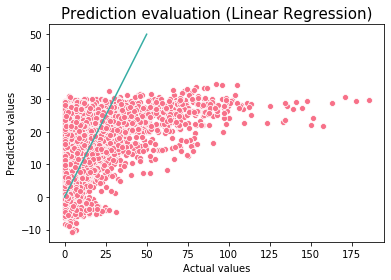

In [39]:
#Plotting the results
sns.scatterplot(y_test,lr_y_pred, color=sns.husl_palette(10)[0])
sns.lineplot([0, 50], [0, 50], color=sns.husl_palette(10)[5])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Prediction evaluation (Linear Regression)', size=15)
plt.show()

In [40]:
x = female[['longitude', 'latitude', 'year', 'age', 'population','gdp', 'gdp/p']]
y = female['suicides/100k pop']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state = 0)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
lr_summary = pd.DataFrame(x.columns.values, columns=['Features'])
lr_summary['Weights'] = lr.coef_
lr_summary

,Features,Weights
0,longitude,0.021496
1,latitude,0.042918
2,year,-0.085753
3,age,0.885901
4,population,0.135507
5,gdp,0.222844
6,gdp/p,-0.024770


In [41]:
rms_test = np.sqrt(mean_squared_error(y_test, lr_y_pred))
rms_test

6.930852432297697

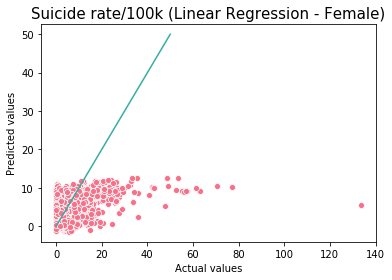

In [42]:
sns.scatterplot(y_test,lr_y_pred, color=sns.husl_palette(10)[0])
sns.lineplot([0, 50], [0, 50], color=sns.husl_palette(10)[5])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Suicide rate/100k (Linear Regression - Female)', size=15)
plt.show()

In [43]:
x = male[['longitude', 'latitude', 'year', 'age','population', 'gdp', 'gdp/p']]
y = male['suicides/100k pop']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state = 0)
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)
lr_summary = pd.DataFrame(x.columns.values, columns=['Features'])
lr_summary['Weights'] = lr.coef_
lr_summary

,Features,Weights
0,longitude,0.046052
1,latitude,0.192830
2,year,-0.051951
3,age,3.452872
4,population,0.387186
5,gdp,0.685268
6,gdp/p,-2.484166


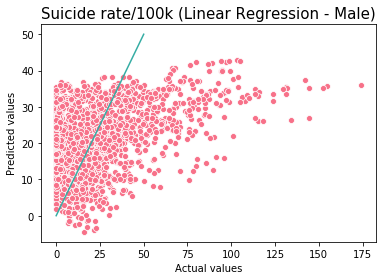

In [44]:
sns.scatterplot(y_test,lr_y_pred, color=sns.husl_palette(10)[0])
sns.lineplot([0, 50], [0, 50], color=sns.husl_palette(10)[5])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Suicide rate/100k (Linear Regression - Male)', size=15)
plt.show()

In [45]:
rms_test = np.sqrt(mean_squared_error(y_test, lr_y_pred))
rms_test

21.149439373287294

In [46]:
nonsexx = processedN[['longitude', 'latitude', 'year', 'age','population', 'gdp', 'gdp/p']]
nonsexy = processedN['suicides/100k pop']
X_train, X_test, y_train, y_test = train_test_split(nonsexx, nonsexy, test_size=.2, random_state = 0)
lrn = LinearRegression()
lrn.fit(X_train, y_train)
lrn_y_pred = lrn.predict(X_test)
lrn_summary = pd.DataFrame(x.columns.values, columns=['Features'])
lrn_summary['Weights'] = lrn.coef_
lrn_summary

,Features,Weights
0,longitude,0.035674
1,latitude,0.120449
2,year,-0.070552
3,age,2.133291
4,population,0.075213
5,gdp,0.616278
6,gdp/p,-1.255845


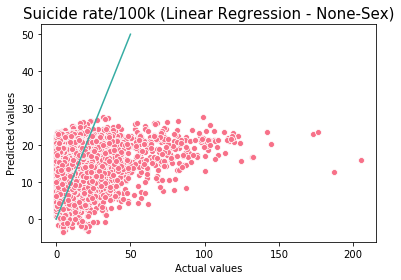

In [47]:
sns.scatterplot(y_test,lrn_y_pred, color=sns.husl_palette(10)[0])
sns.lineplot([0, 50], [0, 50], color=sns.husl_palette(10)[5])
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('Suicide rate/100k (Linear Regression - None-Sex)', size=15)
plt.show()

In [48]:
rms_test = np.sqrt(mean_squared_error(y_test, lrn_y_pred))
rms_test

17.917342218273934

In [49]:
# Selecting the dependent and independent features & set trainning data
x = processedN[['longitude', 'latitude', 'year', 'age', 'female', 'male','population','gdp', 'gdp/p']]
y = processedN['suicides/100k pop']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=.2)


# drop age column for validation
x_drop_age = processedN[['longitude', 'latitude', 'year', 'female', 'male','population','gdp', 'gdp/p']]
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(x_drop_age, y, test_size=.2)


# drop gdp column for validation
x_drop_gdp = processedN[['longitude', 'latitude', 'year', 'female', 'male','population','age', 'gdp/p']]
X_train_gdp, X_test_gdp, y_train_gdp, y_test_gdp = train_test_split(x_drop_gdp, y, test_size=.2)

## Decision Tree

Text(0, 0.5, 'Predicted Rate')

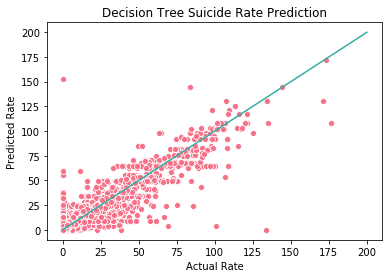

In [50]:
#regression
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(max_depth=10)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# record feature importance
featureImportance["Decision Tree"] = reg.feature_importances_

# plot test ~ prediction y
sns.scatterplot( y_test,y_pred, color=sns.husl_palette(10)[0])
sns.lineplot([0, 200], [0, 200], color=sns.husl_palette(10)[5])
plt.title("Decision Tree Suicide Rate Prediction")
plt.xlabel("Actual Rate")
plt.ylabel("Predicted Rate")

In [51]:
rms_tree = np.sqrt(mean_squared_error(y_test, y_pred))
rms_tree

7.573432156400662

[0.16793287 0.21844963 0.04390593 0.19640491 0.         0.26342623
 0.07029319 0.03958725]


Text(0, 0.5, 'Predicted Rate')

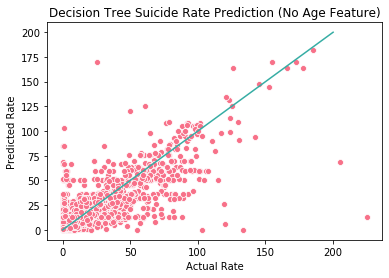

In [52]:
# no age
reg.fit(X_train_age, y_train_age)
y_pred_age = reg.predict(X_test_age)

# record feature importance
print(reg.feature_importances_)

# plot test ~ prediction y
sns.scatterplot( y_test_age, y_pred_age,color=sns.husl_palette(10)[0])
sns.lineplot([0, 200], [0, 200], color=sns.husl_palette(10)[5])
plt.title("Decision Tree Suicide Rate Prediction (No Age Feature)")
plt.xlabel("Actual Rate")
plt.ylabel("Predicted Rate")

In [53]:
rms_tree_age = np.sqrt(mean_squared_error(y_test_age, y_pred_age))
rms_tree_age

11.396313911872179

[0.1443032  0.24129764 0.03752435 0.         0.17278655 0.09702513
 0.2612997  0.04576343]


Text(0, 0.5, 'Predicted Rate')

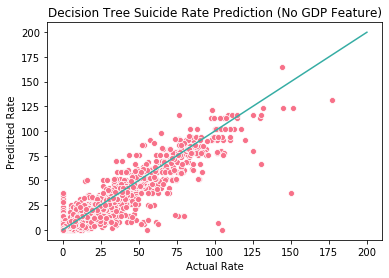

In [68]:
# no gdp
reg.fit(X_train_gdp, y_train_gdp)
y_pred_gdp = reg.predict(X_test_gdp)

# record feature importance
print(reg.feature_importances_)

# plot test ~ prediction y
sns.scatterplot( y_test_gdp,y_pred_gdp, color=sns.husl_palette(10)[0])
sns.lineplot([0, 200], [0, 200], color=sns.husl_palette(10)[5])
plt.title("Decision Tree Suicide Rate Prediction (No GDP Feature)")
plt.xlabel("Actual Rate")
plt.ylabel("Predicted Rate")

In [55]:
rms_tree_gdp = np.sqrt(mean_squared_error(y_test_gdp, y_pred_gdp))
rms_tree_gdp

6.950506227653007

# Random Forest

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Text(0, 0.5, 'Predicted Rate')

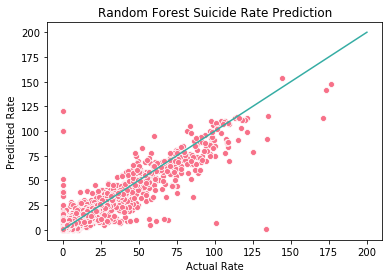

In [56]:
from sklearn.ensemble import RandomForestRegressor
# regression
regf = RandomForestRegressor(max_depth=10, random_state=0)
regf.fit(X_train, y_train)
y_pred = regf.predict(X_test)

# record feature importance
featureImportance["Random Forest"] = regf.feature_importances_

# plot test ~ prediction y
sns.scatterplot( y_test,y_pred, color=sns.husl_palette(10)[0])
sns.lineplot([0, 200], [0, 200], color=sns.husl_palette(10)[5])
plt.title("Random Forest Suicide Rate Prediction")
plt.xlabel("Actual Rate")
plt.ylabel("Predicted Rate")

In [57]:
rms_forest = np.sqrt(mean_squared_error(y_test, y_pred))
rms_forest

6.886200009765385

[0.16532304 0.23207295 0.04514603 0.11667868 0.0779239  0.26098326
 0.06367664 0.03819551]


Text(0, 0.5, 'Predicted Rate')

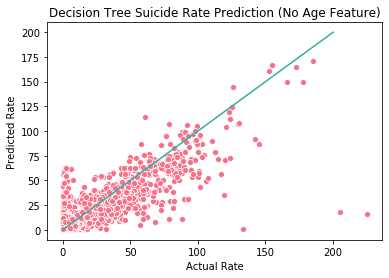

In [58]:
# no age
regf.fit(X_train_age, y_train_age)
y_pred_age = regf.predict(X_test_age)

# record feature importance
print(regf.feature_importances_)

# plot test ~ prediction y
sns.scatterplot(y_test_age, y_pred_age, color=sns.husl_palette(10)[0])
sns.lineplot([0, 200], [0, 200], color=sns.husl_palette(10)[5])
plt.title("Decision Tree Suicide Rate Prediction (No Age Feature)")
plt.xlabel("Actual Rate")
plt.ylabel("Predicted Rate")

In [59]:
rms_forest_age = np.sqrt(mean_squared_error(y_test_age, y_pred_age))
rms_forest_age

10.20520152063898

[0.15115477 0.23887568 0.04361994 0.13655907 0.03368767 0.09108027
 0.25404705 0.05097556]


Text(0, 0.5, 'Predicted Rate')

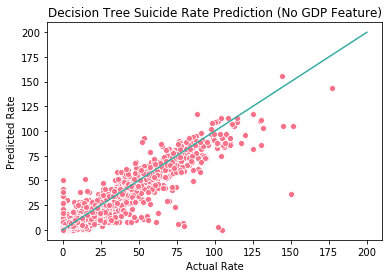

In [69]:
# no gdp
regf.fit(X_train_gdp, y_train_gdp)
y_pred_gdp = regf.predict(X_test_gdp)

# record feature importance
print(regf.feature_importances_)

# plot test ~ prediction y
sns.scatterplot( y_test_gdp,y_pred_gdp, color=sns.husl_palette(10)[0])
sns.lineplot([0, 200], [0, 200], color=sns.husl_palette(10)[5])
plt.title("Decision Tree Suicide Rate Prediction (No GDP Feature)")
plt.xlabel("Actual Rate")
plt.ylabel("Predicted Rate")

In [61]:
rms_forest_gdp = np.sqrt(mean_squared_error(y_test_gdp, y_pred_gdp))
rms_forest_gdp

6.612156010733478

In [62]:
# Check feature importance
featureImportance

,linear,Decision Tree,Random Forest
longitude,0.022214,0.145285,0.152788
latitude,0.073634,0.239931,0.220501
year,-0.045801,0.040447,0.033447
age,1.270266,0.259398,0.255938
female,-4.592257,0.172914,0.138764
male,4.592257,0.000000,0.034029
population,0.163560,0.084948,0.091912
gdp,0.285968,0.023116,0.028548
gdp/p,-0.769840,0.033961,0.044072


In [63]:
output = featureImportance.transpose()
output.to_csv("a.csv")

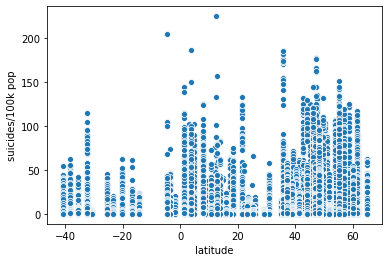

In [65]:
# why would latitude have such strong importance
sns.scatterplot(processedN["latitude"],processedN["suicides/100k pop"])

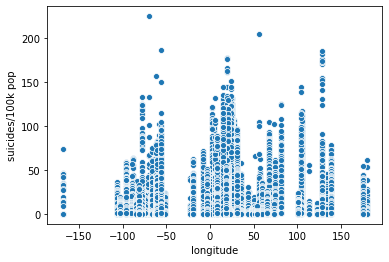

In [67]:
# why would latitude have such strong importance
sns.scatterplot(processedN["longitude"],processedN["suicides/100k pop"])

In [ ]:
# checking for correlation
processedN.corr()

# Perform Cross Validation

In [153]:
treeImportance = []
forestImportance = []

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(x,y)
for train_index, test_index in kf.split(x,y):
    X_train = x.iloc[train_index,:]
    X_test = x.iloc[test_index,:]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
    # decision tree
    
    reg = DecisionTreeRegressor(max_depth=10)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    # record feature importance
    treeImportance.append(reg.feature_importances_)
    
    
    # random forest
    
    reg = RandomForestRegressor(max_depth=10, random_state=0)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)

    # record feature importance
    featureImportance["Decision Tree"] = reg.feature_importances_
    forestImportance.append(reg.feature_importances_)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The de

In [154]:
pd.DataFrame(treeImportance)

,0,1,2,3,4,5,6,7,8
0,0.142984,0.227669,0.025210,0.226340,0.000000,0.177149,0.086214,0.045705,0.068728
1,0.168149,0.208338,0.042969,0.243624,0.000000,0.169654,0.110474,0.032431,0.024361
2,0.123829,0.261612,0.024494,0.260703,0.171558,0.000000,0.087143,0.046726,0.023936
3,0.139966,0.252196,0.029291,0.286645,0.170907,0.000000,0.046452,0.038037,0.036506
4,0.162938,0.225642,0.044917,0.256887,0.000000,0.161830,0.087254,0.024427,0.036106


In [155]:
cvImportance = pd.DataFrame(index= x.columns)
cvImportance["Decision Tree"] = np.mean(treeImportance,axis = 0)
cvImportance["Random Forest"] = np.mean(forestImportance,axis = 0)
cvImportance

,Decision Tree,Random Forest
longitude,0.147573,0.146048
latitude,0.235092,0.230675
year,0.033376,0.032833
age,0.254840,0.255593
female,0.068493,0.088516
male,0.101726,0.080383
population,0.083507,0.084892
gdp,0.037465,0.039727
gdp/p,0.037927,0.041333
